- Reference
  - https://www.bigdata-navi.com/aidrops/2611/
  - https://deepage.net/deep_learning/2016/11/30/resnet.html

Dropout を試す。


In [1]:
import os
import numpy as np
import datetime
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score

In [2]:
np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
root = os.path.join('data')

transform = transforms.Compose([transforms.ToTensor()])

mnist_train = torchvision.datasets.FashionMNIST(
    root=root, download=True, train=True, transform=transform)

mnist_test = torchvision.datasets.FashionMNIST(
    root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=100, shuffle=False)

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### モデル定義

In [9]:
class Block(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        channel = channel_out // 4

        # 1x1 の畳み込み
        self.conv1 = nn.Conv2d(channel_in, channel,
                               kernel_size=(1, 1))
        #self.bn1 = nn.BatchNorm2d(channel)   # Post Activation
        self.bn1 = nn.BatchNorm2d(channel_in) # Pre Activation
        self.relu1 = nn.ReLU()

        # 3x3 の畳み込み
        self.conv2 = nn.Conv2d(channel, channel,
                               kernel_size=(3, 3),
                               padding=1)
        self.bn2 = nn.BatchNorm2d(channel)
        self.relu2 = nn.ReLU()

        # 1x1 の畳み込み
        self.conv3 = nn.Conv2d(channel, channel_out,
                               kernel_size=(1, 1),
                               padding=0)
        #self.bn3 = nn.BatchNorm2d(channel_out) # Post Activation
        self.bn3 = nn.BatchNorm2d(channel)     # Pre Activation

        self.dropout = torch.nn.Dropout2d(p=0.1)

        # skip connection用のチャネル数調整        
        self.shortcut = self._shortcut(channel_in, channel_out)
        
        self.relu3 = nn.ReLU()

    def forward(self, x):
        # h = self.conv1(x)
        # h = self.bn1(h)
        # h = self.relu1(h)

        # h = self.conv2(h)
        # h = self.bn2(h)
        # h = self.relu2(h)

        # h = self.conv3(h)
        # h = self.bn3(h)

        # shortcut = self.shortcut(x)
        # y = self.relu3(h + shortcut)  # skip connection

        # Pre Activation
        h = self.bn1(x)
        h = self.relu1(h)
        h = self.conv1(h)

        h = self.bn2(h)
        h = self.relu2(h)
        h = self.conv2(h)

        h = self.bn3(h)
        h = self.relu3(h)
        h = self.dropout(h)
        h = self.conv3(h)

        shortcut = self.shortcut(x)
        y = h + shortcut  # skip connection

        return y

    def _shortcut(self, channel_in, channel_out):
        if channel_in != channel_out:
            return self._projection(channel_in, channel_out)
        else:
            return lambda x: x

    def _projection(self, channel_in, channel_out):
        return nn.Conv2d(channel_in, channel_out,
                         kernel_size=(1, 1),
                         padding=0)

In [10]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self,
                 device='cpu'):
        super().__init__()

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:]).view(-1, x.size(1))

In [11]:
class ResNet50(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64,
                               kernel_size=(7, 7),
                               stride=(2, 2),
                               padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3),
                                  stride=(2, 2),
                                  padding=1)

        # Block 1
        self.block0 = self._building_block(256, channel_in=64)

        self.block1 = nn.ModuleList([
            self._building_block(256) for _ in range(2)
        ])
        self.conv2 = nn.Conv2d(256, 512,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 2
        self.block2 = nn.ModuleList([
            self._building_block(512) for _ in range(4)
        ])
        self.conv3 = nn.Conv2d(512, 1024,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 3
        self.block3 = nn.ModuleList([
            self._building_block(1024) for _ in range(6)
        ])
        self.conv4 = nn.Conv2d(1024, 2048,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 4
        self.block4 = nn.ModuleList([
            self._building_block(2048) for _ in range(3)
        ])
        self.avg_pool = GlobalAvgPool2d()  # TODO: GlobalAvgPool2d
        self.fc = nn.Linear(2048, 1000)
        self.out = nn.Linear(1000, output_dim)

    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.block0(h)

        for block in self.block1:
            h = block(h)

        h = self.conv2(h)

        for block in self.block2:
            h = block(h)

        h = self.conv3(h)

        for block in self.block3:
            h = block(h)

        h = self.conv4(h)

        for block in self.block4:
            h = block(h)

        h = self.avg_pool(h)
        h = self.fc(h)
        h = torch.relu(h)
        h = self.out(h)
        y = torch.log_softmax(h, dim=-1)

        return y

    def _building_block(self,
                        channel_out,
                        channel_in=None):
        if channel_in is None:
            channel_in = channel_out

        return Block(channel_in, channel_out)

### 学習

In [12]:
class Trainer:
    def __init__(self):
        self.model = ResNet50(10).to(device)
        
        self.criterion = nn.NLLLoss()
        self.optimizer = optimizers.Adam(self.model.parameters(), weight_decay=0.01)
  
        self.epochs = 20
        self.history = pd.DataFrame({}, columns=['epoch', 'loss', 'acc'])
 
    def compute_loss(self, label, pred):
        return self.criterion(pred, label)
    
    def train_step(self, x, t):
        self.model.train()
        preds = self.model(x)
        loss = self.compute_loss(t, preds)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss, preds
    
    def test_step(self, x, t):
        self.model.eval()
        preds = self.model(x)
        loss = self.compute_loss(t, preds)
        return loss, preds

    def train(self):
        print(datetime.datetime.now().isoformat(), 'Start')
        
        for epoch in range(self.epochs):
            train_loss = 0.
            test_loss = 0.
            test_acc = 0.
        
            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                loss, _ = self.train_step(x, t)
                train_loss += loss.item()
        
            train_loss /= len(train_dataloader)
        
            for (x, t) in test_dataloader:
                x, t = x.to(device), t.to(device)
                loss, preds = self.test_step(x, t)
                test_loss += loss.item()
                test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
        
            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)
        
            print(datetime.datetime.now().isoformat(),
                  'Epoch: {}, Valid Cost: {:.3f}, Valid Acc: {:.3f}'.format(
                      epoch+1, test_loss, test_acc))
        
            self.history = self.history.append(
                {'epoch': epoch+1, 'loss': test_loss, 'acc': test_acc},
                ignore_index=True)
        
        print(datetime.datetime.now().isoformat(), 'End')

In [13]:
trainer = Trainer()
trainer.train()

2020-08-20T15:41:51.987669 Start
2020-08-20T15:42:32.189925 Epoch: 1, Valid Cost: 1.313, Valid Acc: 0.382
2020-08-20T15:43:12.252417 Epoch: 2, Valid Cost: 0.559, Valid Acc: 0.805
2020-08-20T15:43:52.314809 Epoch: 3, Valid Cost: 0.470, Valid Acc: 0.842
2020-08-20T15:44:32.413811 Epoch: 4, Valid Cost: 0.462, Valid Acc: 0.849
2020-08-20T15:45:12.412031 Epoch: 5, Valid Cost: 0.421, Valid Acc: 0.858
2020-08-20T15:45:52.560636 Epoch: 6, Valid Cost: 0.428, Valid Acc: 0.859
2020-08-20T15:46:32.540561 Epoch: 7, Valid Cost: 0.426, Valid Acc: 0.853
2020-08-20T15:47:12.688377 Epoch: 8, Valid Cost: 0.403, Valid Acc: 0.863
2020-08-20T15:47:52.800432 Epoch: 9, Valid Cost: 0.411, Valid Acc: 0.853
2020-08-20T15:48:32.991696 Epoch: 10, Valid Cost: 0.364, Valid Acc: 0.876
2020-08-20T15:49:13.052452 Epoch: 11, Valid Cost: 0.402, Valid Acc: 0.860
2020-08-20T15:49:53.145186 Epoch: 12, Valid Cost: 0.443, Valid Acc: 0.850
2020-08-20T15:50:33.211456 Epoch: 13, Valid Cost: 0.361, Valid Acc: 0.874
2020-08-20T15:

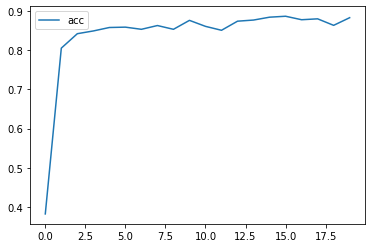

In [14]:
trainer.history[['acc']].plot()

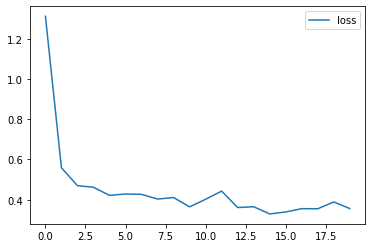

In [15]:
trainer.history[['loss']].plot()